# Image-to-image transition between pipelines

This notebook contains functions to compute metrics between samples generated by different image-to-image transition frameworks. 

In [22]:
from utils.datasets import ImageDataset,ClassifDataset
from torch.utils.data import DataLoader
from glob import glob
from scipy import stats
from statannotations.Annotator import Annotator
from utils import denorm, feature_visualization, metrics
from models import classifier
from nilearn import plotting 
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

import sys 
import importlib
import torch
import os
import random

sns.set_style("whitegrid")

In [2]:
pipelines = ['fsl-5-0-0', 'fsl-5-0-1', 'spm-5-0-0', 'spm-5-0-1']

## Compute metrics

To compute metrics for a particular model: 
- change the variables model ('cc_ddpm', 'c_ddpm' or 'stargan'), 
- the sampling ('', '-kmeans', '-knn')
- and the n value (1, 5, 10, or 20). 

In [3]:
if not os.path.exists('./results/metrics'):
    os.mkdir('./results/metrics')

In [35]:
p_source_list = ['fsl-5-0-0', 'fsl-5-0-1', 'spm-5-0-0', 'spm-5-0-1']
p_target_list = ['fsl-5-0-0', 'fsl-5-0-1', 'spm-5-0-0', 'spm-5-0-1']

### Correlations - MSE - Class change

In [33]:
def compute_metrics(sample_dir, p_source_list, p_target_list, model, n='_n10', w='_w0.5', sampling='-kmeans', nimg=20, add_title=''):
    print(f'Model: {model}, n={n}, w={w}')
    for i, p_source in enumerate(p_source_list):
        for j, p_target in enumerate(p_target_list):
            if p_source != p_target:
            
                corr_st = []
                corr_tg = []
                corr_sg = []
                mse_st = []
                mse_tg = []
                mse_sg = []
                class_trg = []
                class_gen = []
            
                data_trg = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'trg_img-*{w}{n}_orig-{p_source}_target-{p_target}.nii.gz'
                    )
                )[:nimg]
                
                data_gen = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'gen_img-*{w}{n}_orig-{p_source}_target-{p_target}.nii.gz'
                    )
                )[:nimg]
                
                data_src = sorted(
                    glob(
                        f'{sample_dir}/' + \
                        f'src_img-*{w}{n}_orig-{p_source}_target-{p_target}.nii.gz'
                    )
                )[:nimg]

                for i in range(nimg):
            
                    corr_sg.append(
                        metrics.get_correlation(
                            nib.load(data_src[i]), 
                            nib.load(data_gen[i])
                        )
                    )
                    # Source - Target correlations
                    corr_st.append(
                        metrics.get_correlation(
                            nib.load(data_src[i]), 
                            nib.load(data_trg[i])
                        )
                    )
                
                    # Generated - Target correlations
                    corr_tg.append(
                        metrics.get_correlation(
                            nib.load(data_trg[i]), 
                            nib.load(data_gen[i])
                        )
                    )

                    mse_sg.append(
                        metrics.get_difference(
                            nib.load(data_src[i]).get_fdata(), 
                            nib.load(data_trg[i]).get_fdata(), 
                            nii = False
                        )
                    )
                    # Source - Target correlations
                    mse_st.append(
                        metrics.get_difference(
                            nib.load(data_src[i]).get_fdata(), 
                            nib.load(data_trg[i]).get_fdata(),
                            nii = False
                        )
                    )
                
                    # Generated - Target correlations
                    mse_tg.append(
                        metrics.get_difference(
                            nib.load(data_trg[i]).get_fdata(), 
                            nib.load(data_gen[i]).get_fdata(),
                            nii = False
                        )
                    )

                trg_dataset = ImageDataset(data_trg[:nimg])
                trg_loader = DataLoader(
                    trg_dataset, 
                    batch_size=1,
                    shuffle=False)
                
                gen_dataset = ImageDataset(data_gen[:nimg])
                gen_loader = DataLoader(
                    gen_dataset, 
                    batch_size=1,
                    shuffle=False)
                
                src_dataset = ImageDataset(data_src[:nimg])
                src_loader = DataLoader(
                    src_dataset, 
                    batch_size=1,
                    shuffle=False)

                model_param = './results/models/classifier_b-64_lr-1e-04_epochs_150.pth'
            
                for data in trg_loader:
                    class_trg.append(
                        metrics.class_change(model_param, data.float()))
                
                for data in gen_loader:
                    class_gen.append(
                        metrics.class_change(model_param, data.float()))
                    
                df_st = pd.DataFrame(
                    {'Type' :['Source-Target' for i in range(len(corr_st))],
                     'Correlation' : corr_st, 'MSE': mse_st}
                )
            
                df_sg = pd.DataFrame(
                    {'Type' :['Source-Generated' for i in range(len(corr_sg))],
                     'Correlation' : corr_sg, 'MSE': mse_sg}
                )
                
                df_tg = pd.DataFrame(
                    {'Type' :['Target-Generated' for i in range(len(corr_tg))],
                     'Correlation' : corr_tg, 'MSE': mse_tg}
                )

                df = pd.concat([df_st, df_tg, df_sg])

                df_class = pd.DataFrame(
                    {'Target': class_trg,
                    'Generated': class_gen}
                )
                
                df_class.to_csv(f'./results/metrics/class-change-{model}{w}{n}-{p_source}_{p_target}{add_title}.csv')
                df.to_csv(f'./results/metrics/metrics-{model}{w}{n}-{p_source}_{p_target}{add_title}.csv')

In [57]:
# Pix2Pix

sample_dir = './results/samples/pix2pix-rh--rh'
model = 'pix2pix'
n = ''
w=''
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: pix2pix, n=, w=


/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [58]:
# CycleGAN

sample_dir = './results/samples/cycleGAN-rh--rh'
model = 'cycleGAN'
n = ''
w=''
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: cycleGAN, n=, w=


In [59]:
# StarGAN

sample_dir = './results/samples/stargan-rh--rh'
model = 'stargan'
n = ''
w=''
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: stargan, n=, w=


In [60]:
# C_DDPM 

sample_dir = './results/samples/c_ddpm-rh--rh'
model = 'c_ddpm'
n = ''
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: c_ddpm, n=, w=_w0.5


In [61]:
# CC_DDPM N=1

sample_dir = './results/samples/cc_ddpm-rh--rh'
model = 'cc_ddpm'
n = '_n1'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: cc_ddpm, n=_n1, w=_w0.5


In [62]:
# CC_DDPM N=5, 10 20

sample_dir = './results/samples/cc_ddpm-rh--rh'
model = 'cc_ddpm'

n = '_n5'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

n = '_n10'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

n = '_n20'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: cc_ddpm, n=_n5, w=_w0.5
Model: cc_ddpm, n=_n10, w=_w0.5
Model: cc_ddpm, n=_n20, w=_w0.5


In [63]:
# CC_DDPM N=5, 10, 20 KMEANS

sample_dir = './results/samples/cc_ddpm-kmeans-rh--rh'
model = 'cc_ddpm-kmeans'
n = '_n5'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

n = '_n10'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

n = '_n20'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: cc_ddpm-kmeans, n=_n5, w=_w0.5
Model: cc_ddpm-kmeans, n=_n10, w=_w0.5
Model: cc_ddpm-kmeans, n=_n20, w=_w0.5


In [64]:
# CC_DDPM N=10 KNN

sample_dir = './results/samples/cc_ddpm-knn-rh--rh'
model = 'cc_ddpm-knn'
n = '_n10'
w='_w0.5'
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20)

Model: cc_ddpm-knn, n=_n10, w=_w0.5


### Inception Score
This score estimates the quality of a collection of synthetic images based on how well the top-performing classification model classifies them as one of the pipelines. The scores combine both the confidence of the conditional class predictions for each synthetic image (quality) and the integral of the marginal probability of the predicted classes (diversity).
*Images that contain meaningful objects should have a conditional label distribution p(y|x) with low entropy.*

The entropy is calculated as the negative sum of each observed probability multiplied by the log of the probability. The intuition here is that large probabilities have less information than small probabilities.
entropy = -sum(p_i * log(p_i))

To capture our interest in a variety of images, we use the marginal probability. This is the probability distribution of all generated images. We, therefore, would prefer the integral of the marginal probability distribution to have a high entropy.
*Moreover, we expect the model to generate varied images, so the marginal integral p(y|x = G(z))dz should have high entropy.*

— Improved Techniques for Training GANs, 2016.

These elements are combined by calculating the Kullback-Leibler divergence, or KL divergence (relative entropy), between the conditional and marginal probability distributions.

Calculating the divergence between two distributions is written using the “||” operator, therefore we can say we are interested in the KL divergence between C for conditional and M for marginal distributions or:

KL (C || M)
Specifically, we are interested in the average of the KL divergence for all generated images.

Combining these two requirements, the metric that we propose is: exp(Ex KL(p(y|x)||p(y))).

In [28]:
model_param = './results/models/classifier_b-64_lr-1e-04_epochs_150.pth'

classifier = classifier.Classifier3D(
    n_class = 4
    )

classifier.load_state_dict(
    torch.load(
        model_param, 
        map_location='cpu'
    )
)

<All keys matched successfully>

In [40]:
config = {
    'model':['pix2pix', 'cycleGAN','stargan','c_ddpm', 'cc_ddpm','cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm'], 
    'n' : ['', '','','','_n1','_n5', '_n10', '_n20', '_n5', '_n10', '_n20', '_n10'],
    'sampling' : ['', '','','', '', '-kmeans', '-kmeans', '-kmeans', '','','', '-knn'],
    'w':['','','','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5']
}

for i in range(len(config['model'])):

    n = config['n'][i]
    sampling = config['sampling'][i]
    model = config['model'][i]
    w=config['w'][i]

    sample_dir = f'./results/samples/{model}{sampling}-rh--rh'
    
    data_trg = sorted(glob(f'{sample_dir}/trg_img-*{w}{n}_orig-*_target-*.nii.gz'))[:80]
    
    trg_dataset = ImageDataset(data_trg)
    trg_loader = DataLoader(
        trg_dataset, 
        batch_size=80,
        shuffle=True)
    
    data_gen = sorted(glob(f'{sample_dir}/gen_img-*{w}{n}_orig-*_target-*.nii.gz'))[:80]
    
    gen_dataset = ImageDataset(data_gen)
    gen_loader = DataLoader(
        gen_dataset, 
        batch_size=80,
        shuffle=True)
    
    is_gen = []
    
    for data in gen_loader:
        act = classifier(data.float().to('cpu'))
        is_gen.append(metrics.get_inception_score(act.detach().numpy()))
    
    is_trg = []
    
    for data in trg_loader:
        act = classifier(data.float().to('cpu'))
        is_trg.append(metrics.get_inception_score(act.detach().numpy()))

    print(model, n, sampling)
    print('Inception score TARGET:', np.mean(is_trg))
    print('Inception score GENERATED:', np.mean(is_gen))

./results/samples/pix2pix-rh--rh/trg_img-*_orig-*_target-*.nii.gz
pix2pix  
Inception score TARGET: 3.9999747 ( 0.0 )
Inception score GENERATED: 3.9999886 ( 0.0 )
./results/samples/cycleGAN-rh--rh/trg_img-*_orig-*_target-*.nii.gz
cycleGAN  
Inception score TARGET: 3.9999747 ( 0.0 )
Inception score GENERATED: 3.8201122 ( 0.0 )
./results/samples/stargan-rh--rh/trg_img-*_orig-*_target-*.nii.gz
stargan  
Inception score TARGET: 3.9999847 ( 0.0 )
Inception score GENERATED: 3.9998422 ( 0.0 )
./results/samples/c_ddpm-rh--rh/trg_img-*_w0.5_orig-*_target-*.nii.gz
c_ddpm  
Inception score TARGET: 3.9999952 ( 0.0 )
Inception score GENERATED: 3.9279268 ( 0.0 )
./results/samples/cc_ddpm-rh--rh/trg_img-*_w0.5_n1_orig-*_target-*.nii.gz
cc_ddpm _n1 
Inception score TARGET: 3.9999847 ( 0.0 )
Inception score GENERATED: 3.9594758 ( 0.0 )
./results/samples/cc_ddpm-kmeans-rh--rh/trg_img-*_w0.5_n5_orig-*_target-*.nii.gz
cc_ddpm _n5 -kmeans
Inception score TARGET: 3.9999847 ( 0.0 )
Inception score GENERATED:

## Reproduce figures

### Table 1: Performance associated with four transfers for GAN-based frameworks

In [97]:
config = {
    'model':['pix2pix','cycleGAN', 'stargan'], 
    'n' : ['', '',  ''],
    'sampling' : ['', '', ''],
    'w':['','','']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    n = config['n'][i]
    sampling = config['sampling'][i]
    model = config['model'][i]
    w = config['w'][i]
    printer = f'{model} & '
    printer_source = f'Source & '
    for t_idx, t in enumerate(transfer):
        corr_df = f'./results/metrics/metrics-{model}{sampling}{w}{n}-{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}.csv'
        df = pd.read_csv(corr_df)
        corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()[:20]
        mse = df['MSE'].loc[df['Type']=='Target-Generated'].tolist()[:20]

        if i ==0 :
            printer_source += str(round(np.mean(df['Correlation'].loc[df['Type']=='Source-Target'].tolist()[:20])*100,1)) + ' & '
            printer_source += str(round(np.mean(df['MSE'].loc[df['Type']=='Source-Target'].tolist()[:20]),4)) + ' & '
    
        printer += str(round(np.mean(corr)*100,1)) + ' & '
        printer += str(round(np.mean(mse),4)) + ' & '

    if i ==0 :
        print(printer_source)
    print(printer)

Source & 78.2 & 0.0076 & 78.2 & 0.0076 & 82.8 & 0.0041 & 92.3 & 0.0022 & 
pix2pix & 91.4 & 0.0027 & 89.1 & 0.0014 & 90.1 & 0.0025 & 97.4 & 0.0005 & 
cycleGAN & 85.5 & 0.0049 & 67.1 & 0.0049 & 70.0 & 0.0072 & 71.2 & 0.0048 & 
stargan & 90.5 & 0.0035 & 86.8 & 0.002 & 87.6 & 0.0035 & 91.5 & 0.0017 & 


### Table 2: Performance associated with four transfers for DM-based frameworks

In [90]:
config = {
    'model':['c_ddpm','cc_ddpm', 'cc_ddpm'], 
    'n' : ['', '_n1', '_n10'],
    'sampling' : ['', '', '-kmeans'],
    'w':['_w0.5','_w0.5','_w0.5']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer = ''
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]
        w = config['w'][i]

        corr_df = f'./results/metrics/metrics-{model}{sampling}{w}{n}-{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}.csv'
        df = pd.read_csv(corr_df)
        corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()[:20]
        mse = df['MSE'].loc[df['Type']=='Target-Generated'].tolist()[:20]

        if i ==0 :
            printer_source += str(round(np.mean(df['Correlation'].loc[df['Type']=='Source-Target'].tolist()[:20])*100,1)) + ' & '
            printer_source += str(round(np.mean(df['MSE'].loc[df['Type']=='Source-Target'].tolist()[:20]),4)) + ' & '

        printer += str(round(np.mean(corr)*100,1)) + ' & '
        printer += str(round(np.mean(mse),4)) + ' & '

    if i ==0 :
        print(printer_source)
    print(printer)

76.5 & 0.008 & 76.2 & 0.008 & 82.8 & 0.004 & 91.1 & 0.0022 & 
83.9 & 0.0097 & 75.0 & 0.0048 & 78.8 & 0.0088 & 81.1 & 0.0043 & 
85.4 & 0.0053 & 77.4 & 0.0037 & 80.1 & 0.0073 & 82.8 & 0.0037 & 
86.1 & 0.0043 & 78.9 & 0.0028 & 81.5 & 0.0049 & 84.1 & 0.0029 & 


### Figure 1 - Boxplot

/var/folders/k4/cck9mrt578q044z6x6zmsnc400m_jt/T/ipykernel_46313/682465372.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.boxplot(data=df_figure, x='Model', y='Correlation', palette="Spectral")


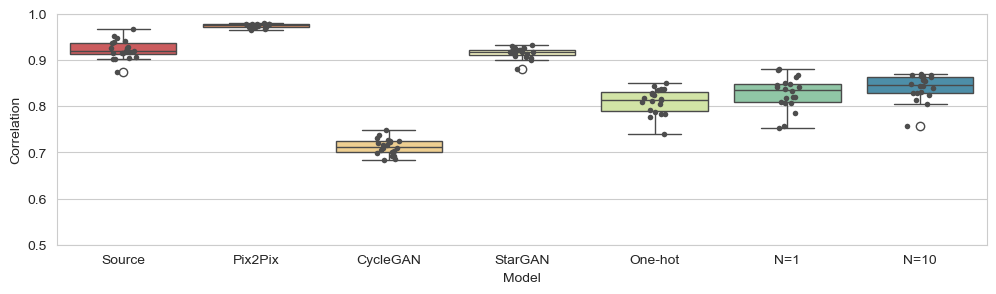

In [104]:
config = {
    'model':['pix2pix','cycleGAN', 'stargan','c_ddpm','cc_ddpm', 'cc_ddpm'], 
    'n' : ['', '',  '','', '_n1', '_n10'],
    'sampling' : ['', '', '','', '', '-kmeans'],
    'w':['','','','_w0.5','_w0.5','_w0.5']
}

titles = ['Pix2Pix', 'CycleGAN', 'StarGAN', 'One-hot', 'N=1', 'N=10']

transfer = (1,0)

df_figure = pd.DataFrame({'Correlation':[], 'Model':[]})

for i in range(len(config['model'])):
    n = config['n'][i]
    sampling = config['sampling'][i]
    model = config['model'][i]
    w = config['w'][i]

    corr_df = f'./results/metrics/metrics-{model}{sampling}{w}{n}-{pipelines[transfer[0]]}_{pipelines[transfer[1]]}.csv'
    df = pd.read_csv(corr_df)
    corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()[:20]

    if i == 0:
        init = df['Correlation'].loc[df['Type']=='Source-Target'][:20]
        df_init = pd.DataFrame({'Correlation':init, 'Model':['Source' for r in range(20)]})
        df_figure = pd.concat([df_figure, df_init])

    df_model = pd.DataFrame({'Correlation':corr, 'Model': f'{titles[i]}'})
    df_figure = pd.concat([df_figure, df_model])

f, ax = plt.subplots(1,1, figsize=(12,3))
ax.set_ylim((0.5,1))
g2 = sns.stripplot(data=df_figure, x='Model', y='Correlation', size=4, color=".3")
g = sns.boxplot(data=df_figure, x='Model', y='Correlation', palette="Spectral")

plt.savefig('./results/figures/correlations-boxplot-fsl-5-0-1_to_fsl-5-0-0.png')

### Table 3: Impact of multi-target images 

In [51]:
config = {
    'model':['cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm', 'cc_ddpm'], 
    'n' : ['_n5', '_n10', '_n20', '_n5', '_n10', '_n20', '_n10'],
    'sampling' : ['-kmeans', '-kmeans', '-kmeans', '', '', '', '-knn'],
    'w':['_w0.5','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5','_w0.5']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer = ''
    printer_source = ''
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]
        w = config['w'][i]

        corr_df = f'./results/metrics/metrics-{model}{sampling}{w}{n}-{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}.csv'
        df = pd.read_csv(corr_df)
        corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()[:20]
        mse = df['MSE'].loc[df['Type']=='Target-Generated'].tolist()[:20]
    
        printer += str(round(np.mean(corr)*100,1)) + ' & '

        printer += str(round(np.mean(mse),4)) + ' & '

    print(printer)

86.5 & 0.0045 & 78.5 & 0.0029 & 81.9 & 0.0048 & 84.1 & 0.003 & 
86.1 & 0.0043 & 78.9 & 0.0028 & 81.5 & 0.0049 & 84.1 & 0.0029 & 
86.5 & 0.0041 & 79.0 & 0.003 & 81.9 & 0.0048 & 84.1 & 0.003 & 
86.3 & 0.0047 & 78.8 & 0.0032 & 81.4 & 0.0054 & 84.5 & 0.0034 & 
86.2 & 0.0048 & 78.3 & 0.0031 & 81.3 & 0.0048 & 83.9 & 0.0031 & 
86.3 & 0.0049 & 78.3 & 0.0035 & 81.6 & 0.0055 & 84.3 & 0.003 & 
85.0 & 0.005 & 78.3 & 0.0042 & 81.8 & 0.0046 & 83.3 & 0.003 & 


### Figure 2

In [14]:
def plot_maps(config, transfer, titles, fig_title):
    f,ax = plt.subplots(len(transfer),5, figsize=(10, 2.5 * len(transfer)))
    
    for t_idx, t in enumerate(transfer):
        for i in range(len(config['model'])):
            printer = ''
            printer_orig = ''
                
            n = config['n'][i]
            sampling = config['sampling'][i]
            model = config['model'][i]
            w = config['w'][i]
            
    
            sample_dir = f'./results/samples/{model}{sampling}-rh--rh'
            
            gen_img = sorted(glob(
                    f'{sample_dir}/gen_img-*{w}{n}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz'))[0]
            src_img = sorted(glob(
                    f'{sample_dir}/src_img-*{w}{n}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz'))[0]
            trg_img = sorted(glob(
                    f'{sample_dir}/trg_img-*{w}{n}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz'))[0]
            
             # Initial 
            display = plotting.plot_glass_brain(
                src_img,
                colorbar=False,
                cmap=nilearn_cmaps['cold_hot'], 
                annotate=False,
                plot_abs=False, 
                title = str(round(metrics.get_correlation(nib.load(src_img), nib.load(trg_img))*100,1)) + '%',
                display_mode='z',
                vmin=-1,
                vmax=1, 
                threshold=0,
                figure=f, 
                axes=ax[t_idx, 0]
            )
    
            ax[t_idx, 0].set_title(titles[t_idx][0], fontsize=14, fontweight='bold')
            
            # Ground truth
            display = plotting.plot_glass_brain(
                trg_img,
                cmap=nilearn_cmaps['cold_hot'], annotate=False,
                plot_abs=False, 
                display_mode='z', vmin=-1, vmax=1,threshold=0,
                figure=f, axes=ax[t_idx, -1]
            )
    
            ax[t_idx, 1].set_title(titles[t_idx][1], fontsize=14, fontweight='bold')
            
            # QC
            display = plotting.plot_glass_brain(
                metrics.mask(trg_img, gen_img),
                cmap=nilearn_cmaps['cold_hot'], 
                annotate=False,
                plot_abs=False, 
                title =str(round(metrics.get_correlation(nib.load(gen_img), nib.load(trg_img))*100,1)) + '%', 
                display_mode='z', 
                vmin=-1, 
                vmax=1,
                threshold=0,
                figure=f, 
                axes=ax[t_idx, i+1],
            )
    
            ax[t_idx, i+2].set_title(titles[t_idx][i+2], fontsize=14, fontweight='bold')
    
    plt.savefig(f'./results/figures/{fig_title}.png')

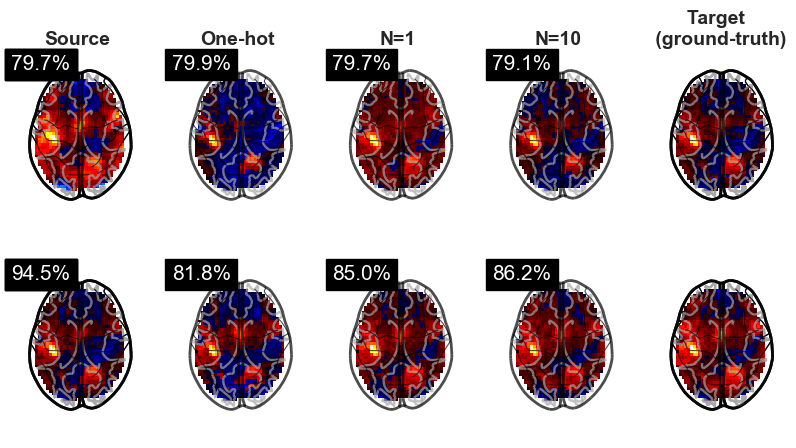

In [15]:
config = {
    'model':['c_ddpm','cc_ddpm', 'cc_ddpm'], 
    'n' : ['', '_n1',  '_n10'],
    'sampling' : ['', '', '-kmeans'],
    'w':['_w0.5', '_w0.5', '_w0.5']
}

titles = [['Source', 'One-hot', 'N=1', 'N=10', 'Target \n (ground-truth)'], 
          ['','','','','']]

transfer = [
    (2,1),
    (1,0),
]

plot_maps(config, transfer, titles, 'figures-ddpm')

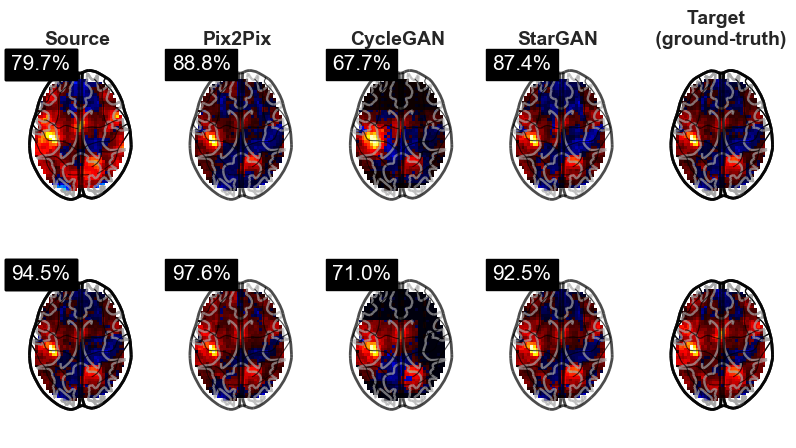

In [17]:
config = {
    'model':['pix2pix','cycleGAN', 'stargan'], 
    'n' : ['', '',  ''],
    'sampling' : ['', '', ''],
    'w':['', '', '']
}

titles = [['Source', 'Pix2Pix', 'CycleGAN', 'StarGAN', 'Target \n (ground-truth)'], 
          ['','','','','']]

transfer = [
    (2,1),
    (1,0),
]

plot_maps(config, transfer, titles, 'figures-gans')

## Supplementary figures

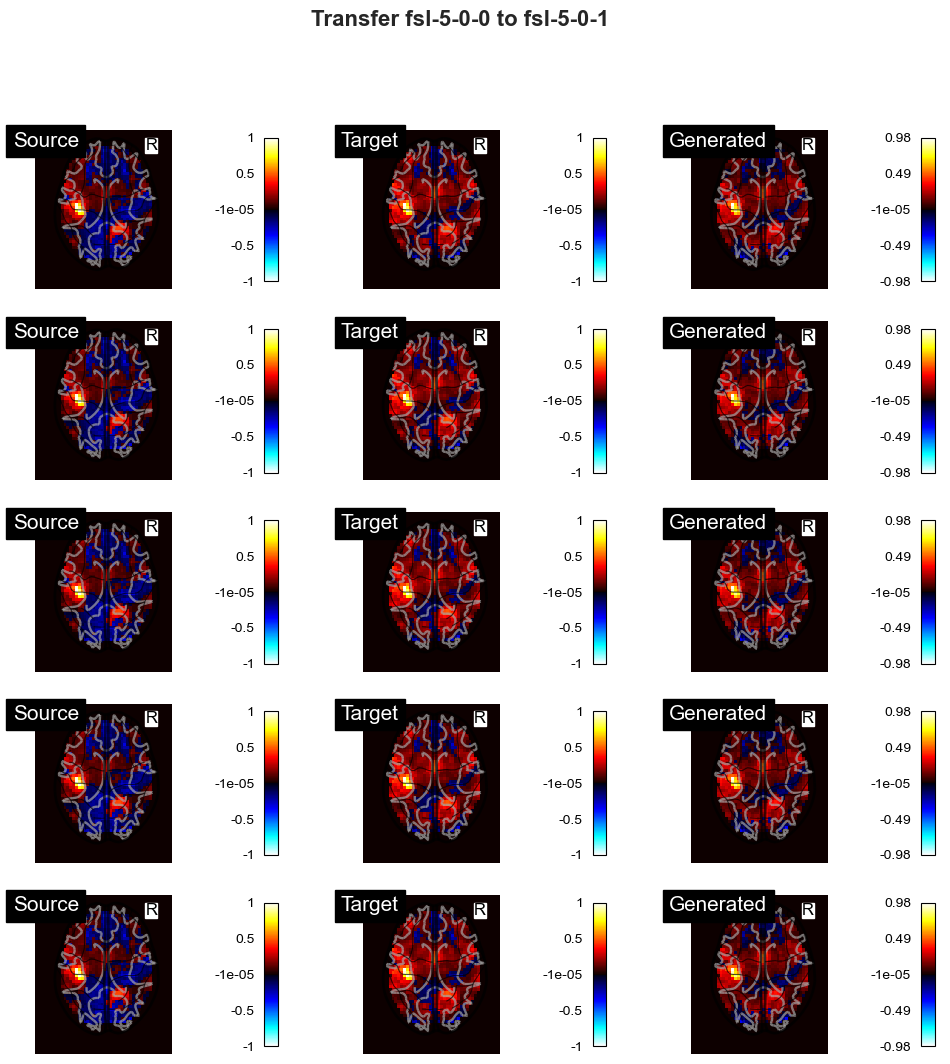

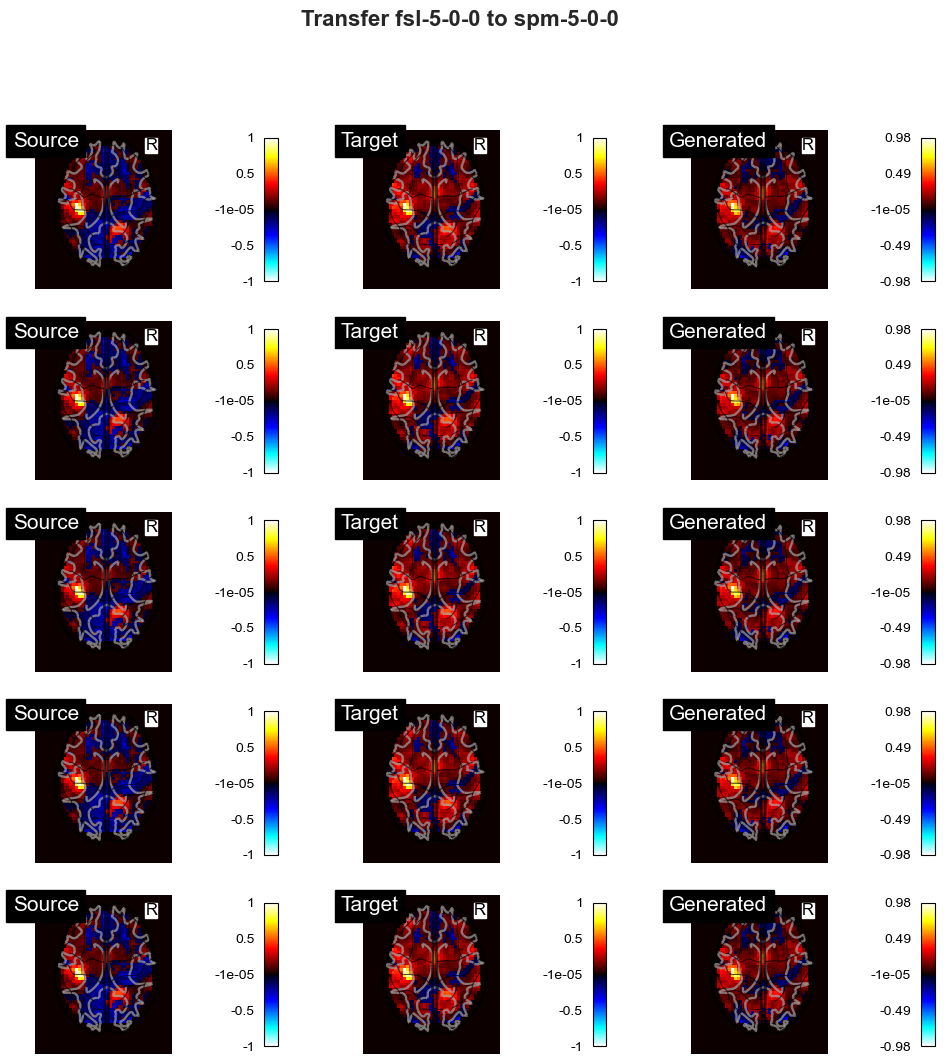

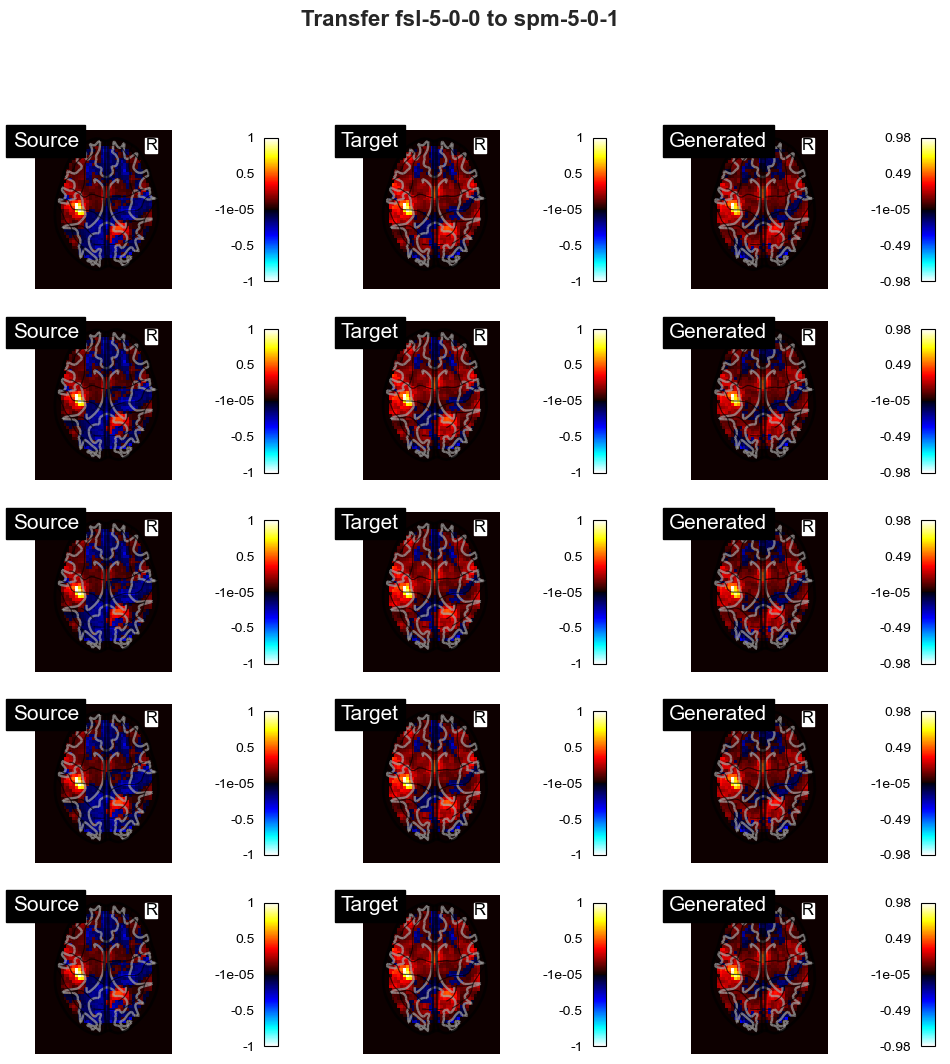

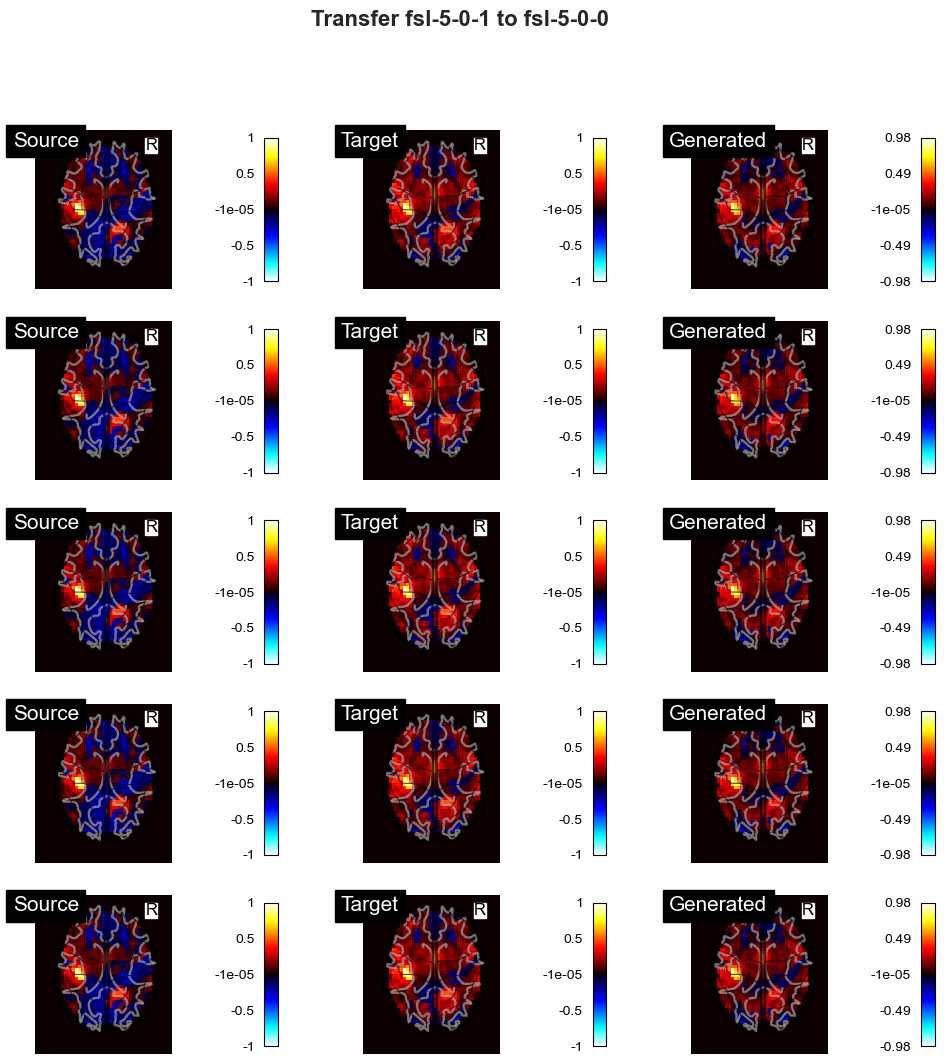

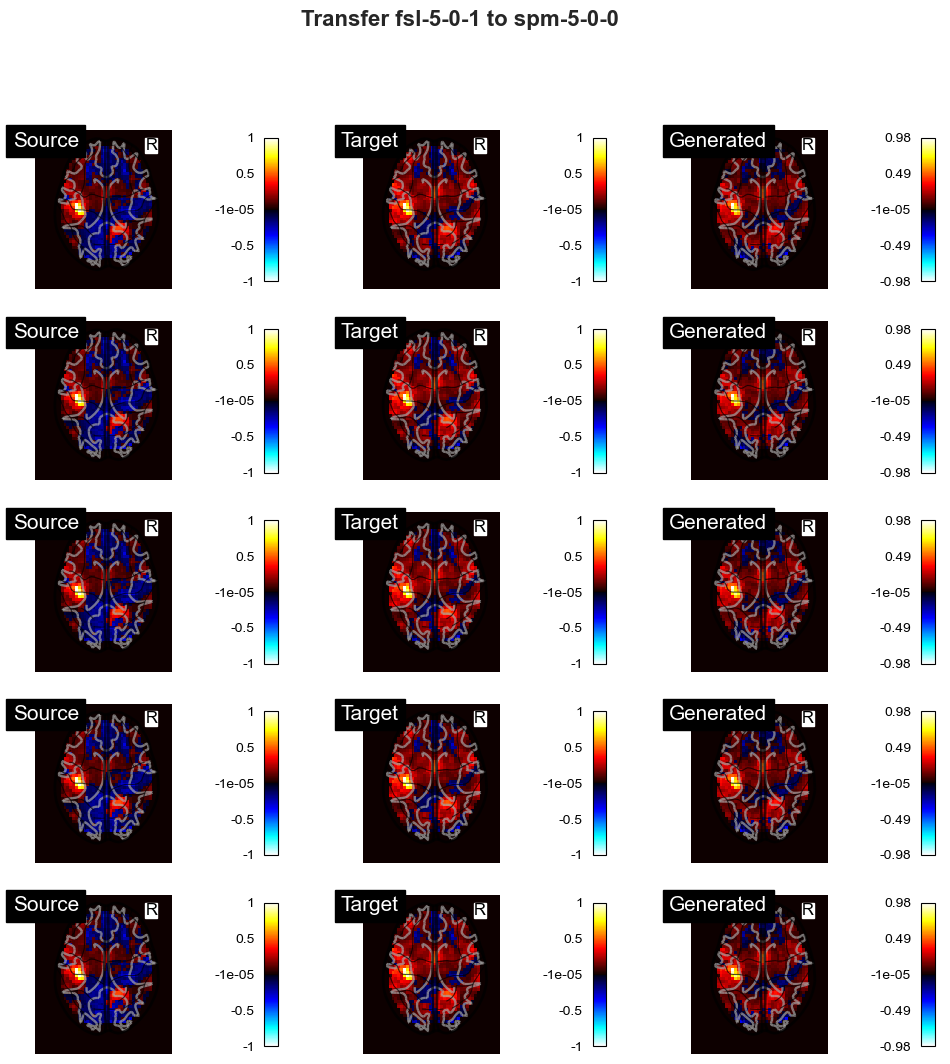

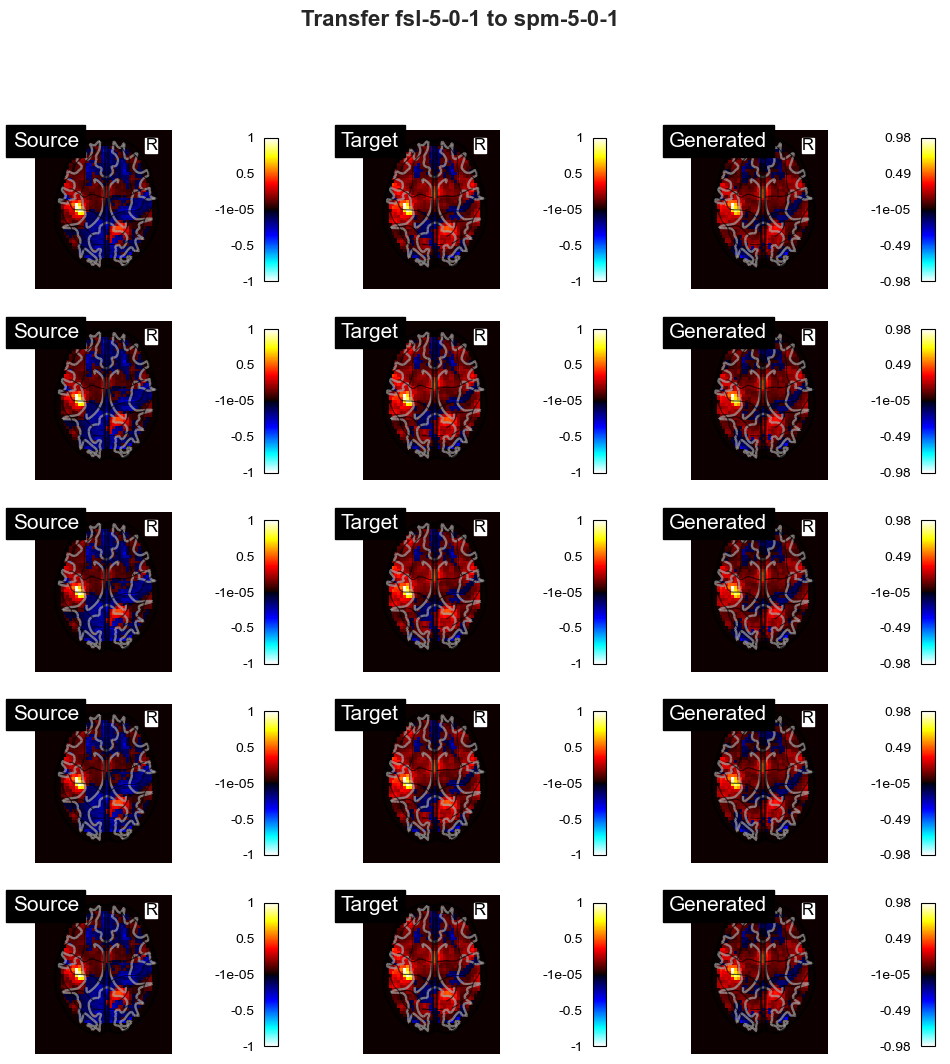

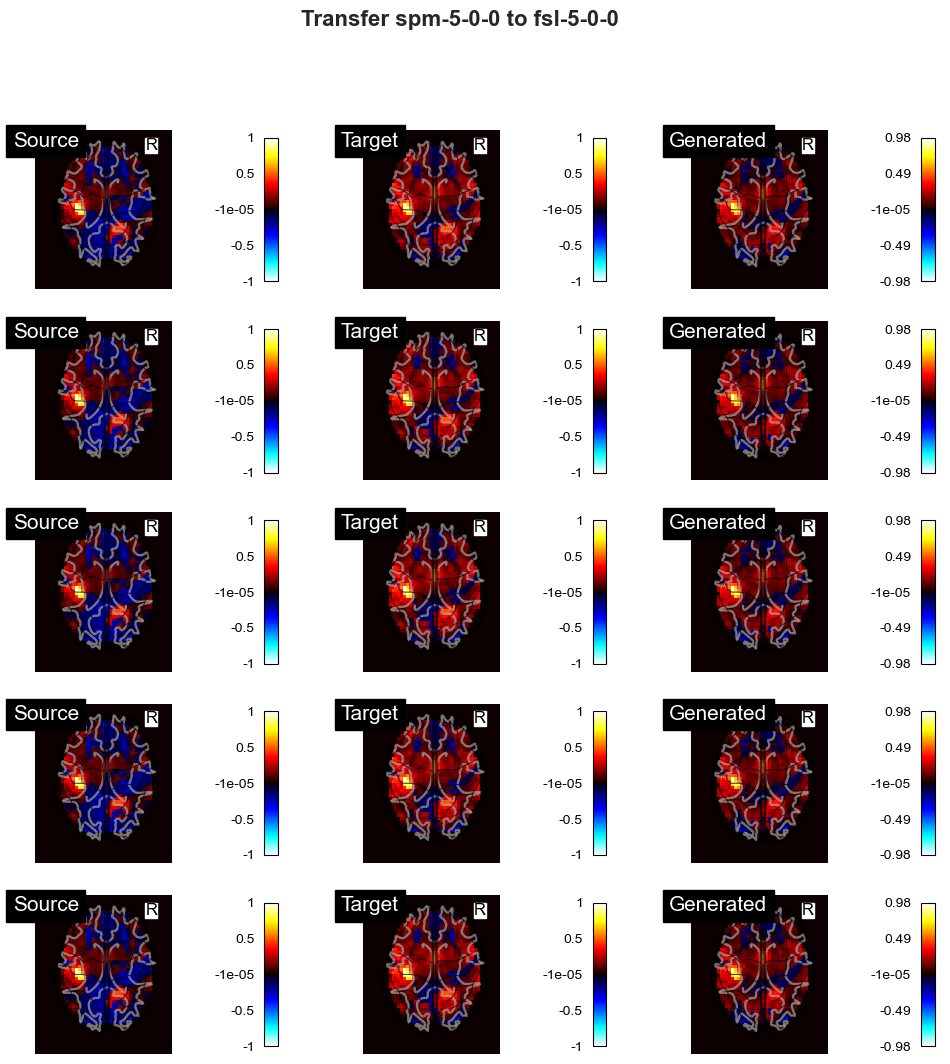

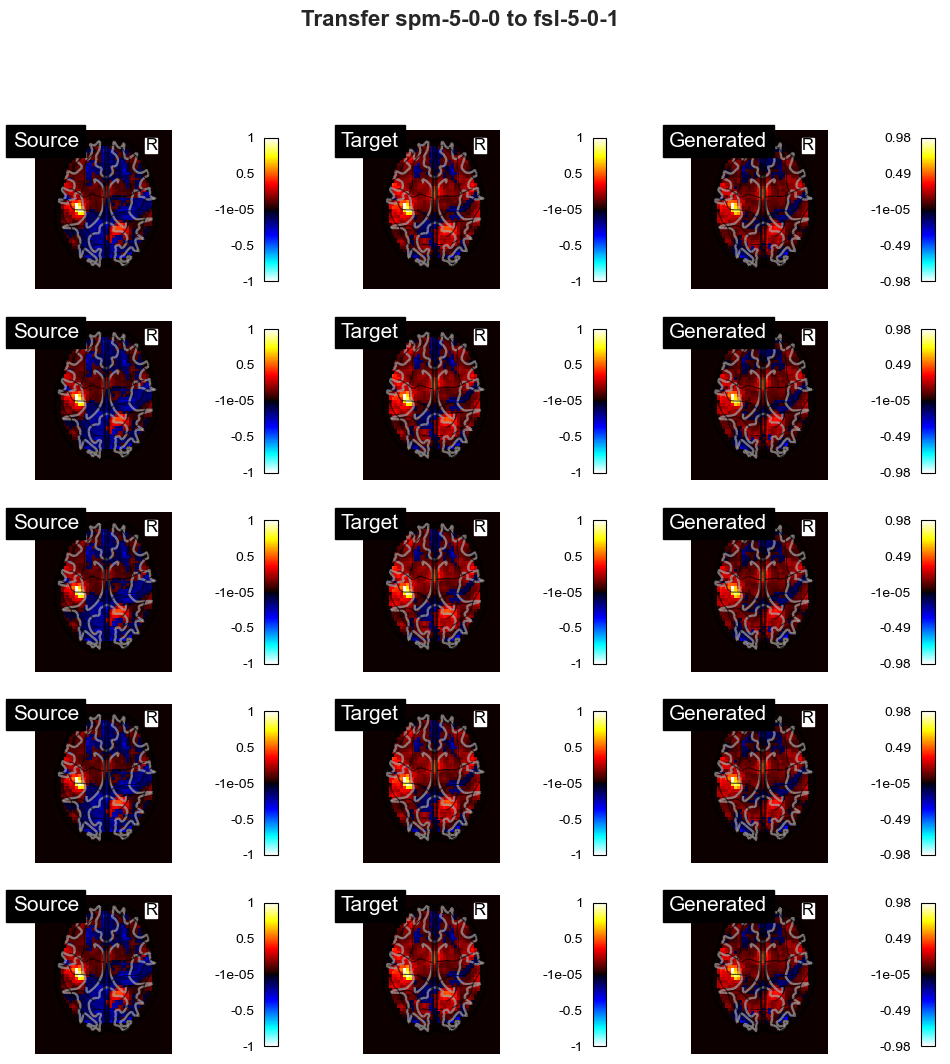

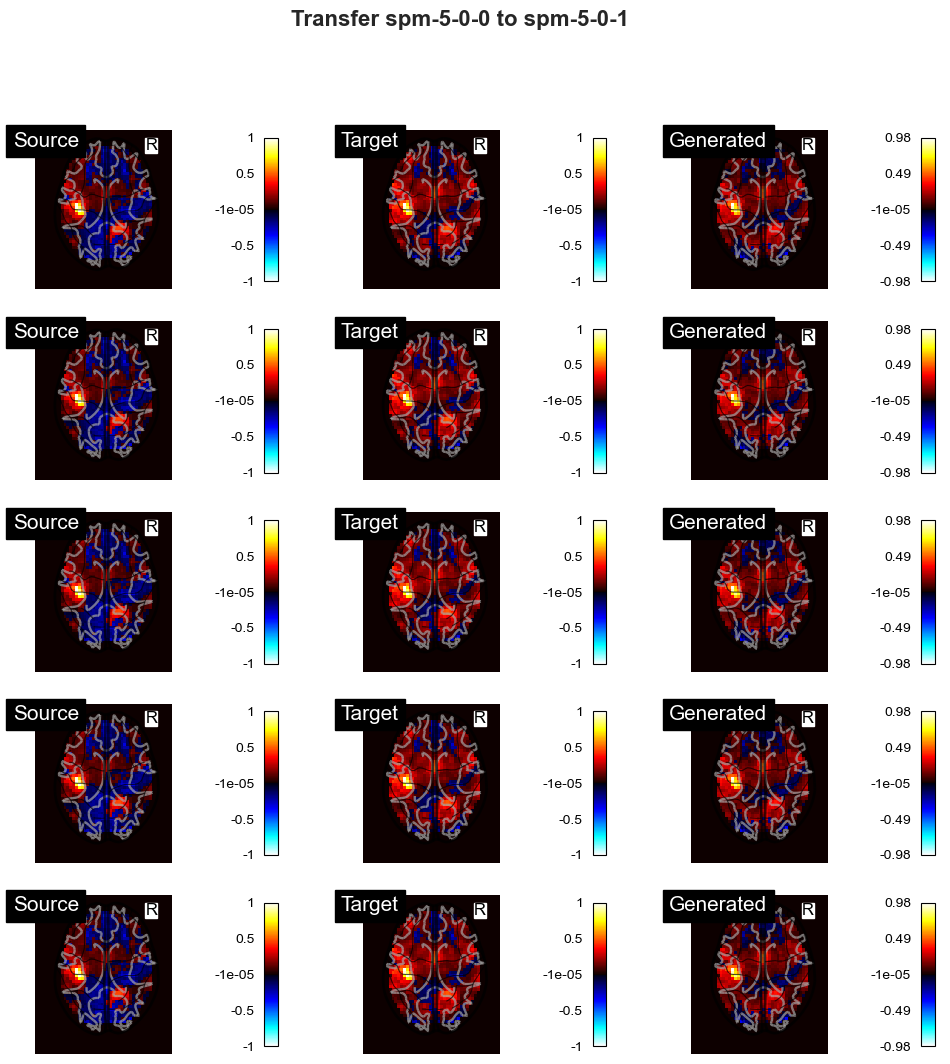

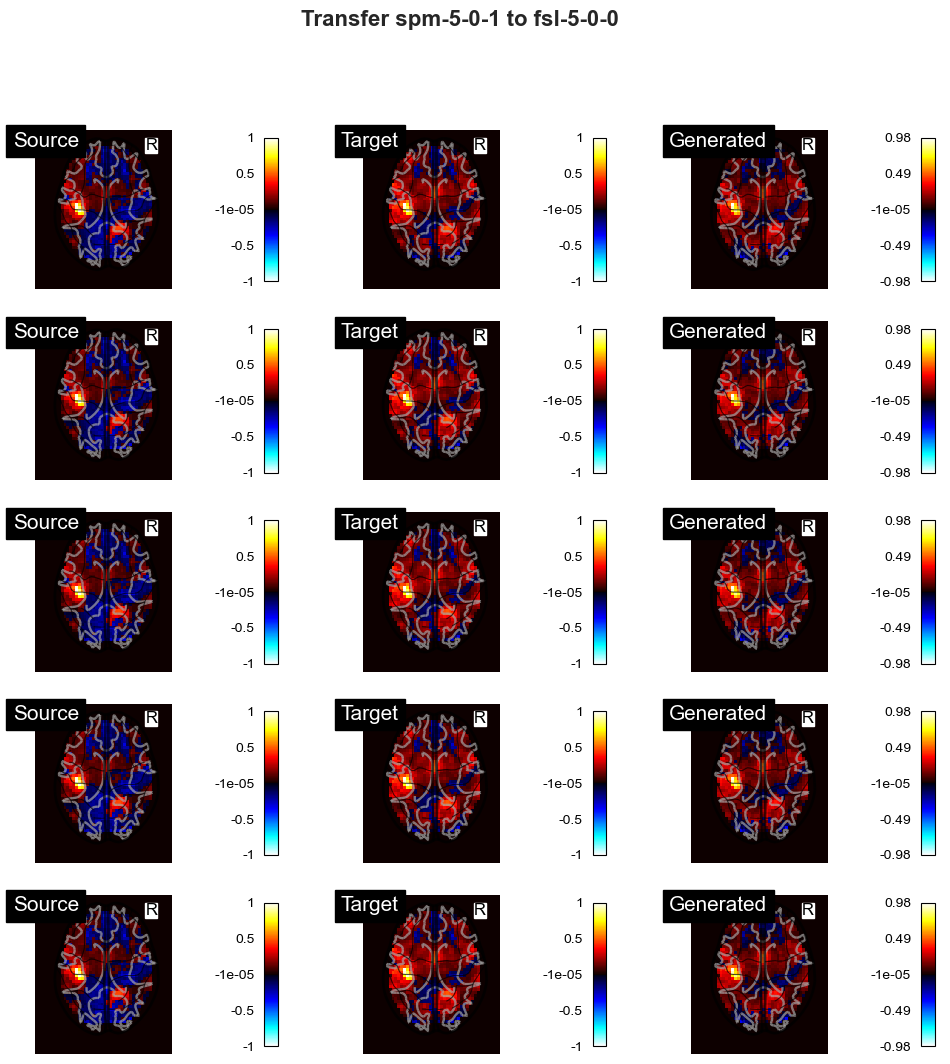

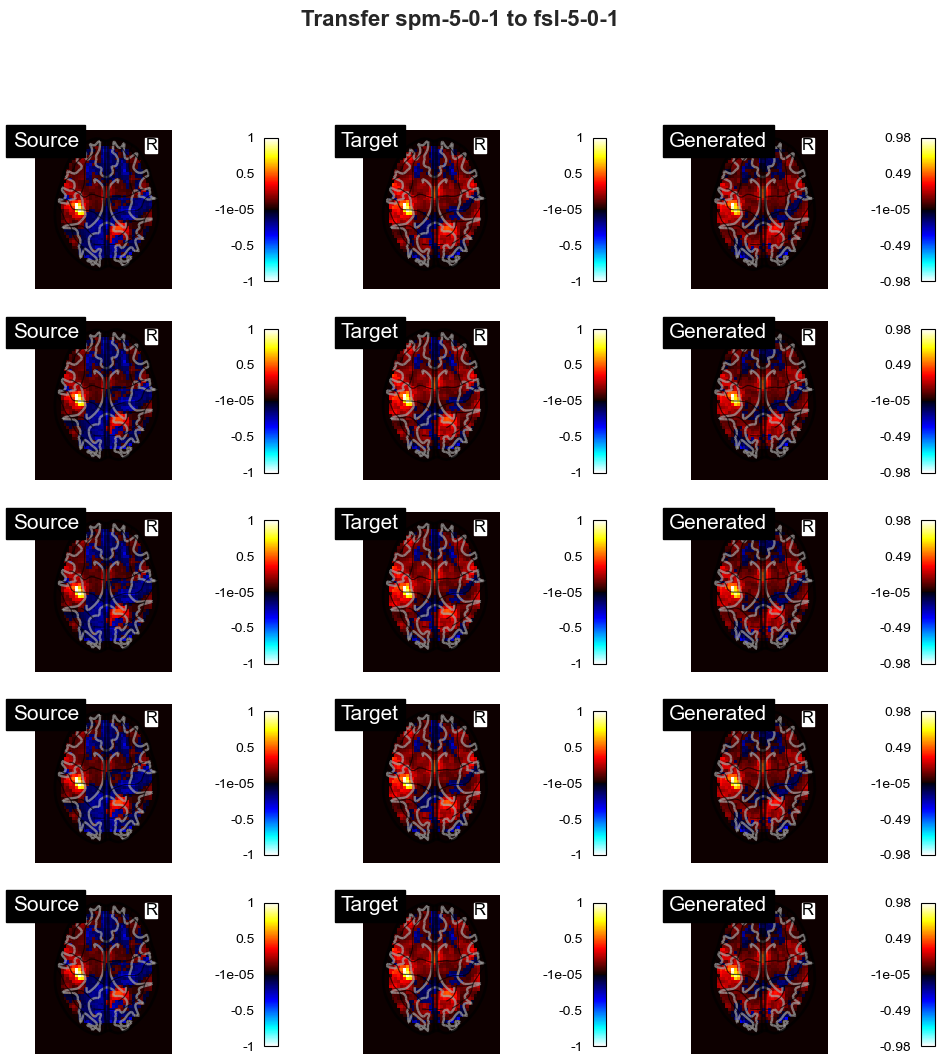

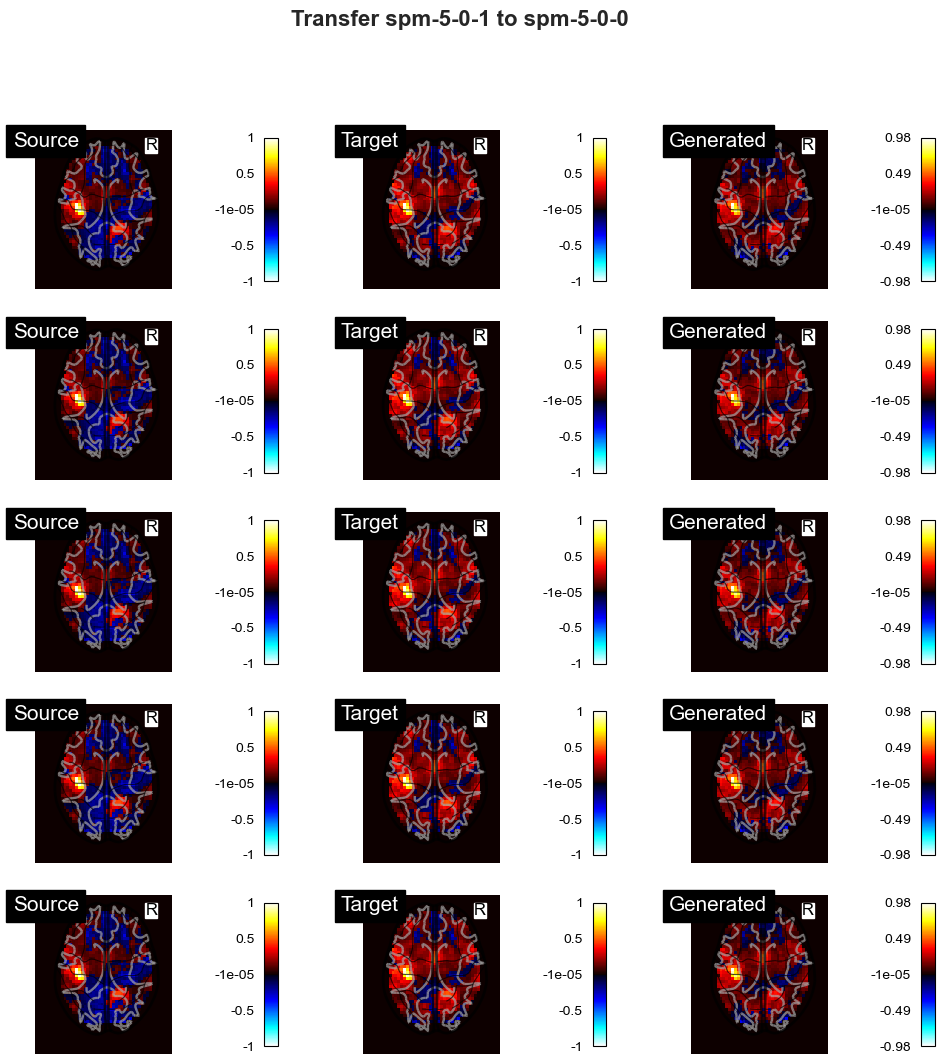

In [19]:
config = {
    'model':['cc_ddpm'], 
    'n' : ['_n10'],
    'sampling' : ['-kmeans'],
    'w':['_w0.5']
} # Change config to visualize other models

transfer = [(i,j) for i in range(4) for j in range(4) if i!=j]

for t_idx, t in enumerate(transfer):
    f,ax = plt.subplots(5,3, figsize=(12, 12))
    for j in range(5):
        for i in range(len(config['model'])):
            printer = ''
            printer_orig = ''
                
            n = config['n'][i]
            sampling = config['sampling'][i]
            model = config['model'][i]
            w = config['w'][i]
        
            sample_dir = f'./results/samples/{model}{sampling}-rh--rh'

            gen_img = sorted(glob(
                    f'{sample_dir}/gen_img-*{w}{n}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz'))
            src_img = sorted(glob(
                    f'{sample_dir}/src_img-*{w}{n}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz'))
            trg_img = sorted(glob(
                    f'{sample_dir}/trg_img-*{w}{n}_orig-{pipelines[t[0]]}_target-{pipelines[t[1]]}.nii.gz'))
        
            
             # Initial 
            display = plotting.plot_glass_brain(
                src_img_list[0],
                colorbar=True,
                cmap=nilearn_cmaps['cold_hot'],
                plot_abs=False,
                display_mode='z',
                figure=f, axes=ax[j, 0], title='Source',
            )
            
            # Ground truth
            display = plotting.plot_glass_brain(
                trg_img_list[0],
                colorbar=True,
                cmap=nilearn_cmaps['cold_hot'],
                plot_abs=False,
                display_mode='z',
                figure=f, axes=ax[j, 1], title='Target',
            )
            # QC
            display = plotting.plot_glass_brain(
                metrics.mask(trg_img_list[0], gen_img_list[0]),
                colorbar=True,
                cmap=nilearn_cmaps['cold_hot'],
                plot_abs=False,
                display_mode='z',
                figure=f, axes=ax[j, i+2], title='Generated'
            )

    f.suptitle(f'Transfer {pipelines[t[0]]} to {pipelines[t[1]]}', fontsize=16, fontweight='bold')
    #plt.savefig(f'./results/supp-figure_transfer-{pipelines[t[0]]}_{pipelines[t[1]]}.png')

In [21]:
from PIL import Image

# Create the frames
frames = []
imgs = glob("./results/supp-figure_transfer*.png")
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)

# Save into a GIF file that loops forever
frames[0].save('./results/transfers.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=1000, loop=0)

#### Supplementary Table 1 - Feature correlations

In [ ]:
model_param = './results/models/classifier_b-64_lr-1e-04_epochs_150.pth'

model = classifier.Classifier3D(
			n_class = 4
			)
model.load_state_dict(
		torch.load(
			model_param, 
			map_location='cpu'
			)
		)


dataset_file = './data/test-dataset_rh_4classes-jeanzay.csv'
label_column = 'pipelines'
dataset = ClassifDataset(dataset_file, label_column)


feature_visualization.get_correlation_features(model, dataset)

In [ ]:
df_correlations = pd.read_csv('./results/metrics/classifier-correlations.csv')

In [ ]:
for transfer in np.unique(df_correlations['Transfer']):
    printer = str(transfer)
    for layer in range(1, 5):
        corr = round(df_correlations['Correlation'].loc[
        (df_correlations['Transfer']==transfer) & (df_correlations['Layer']==layer)
        ].tolist()[0] * 100, 1)

        printer += ' & ' 
        printer += str(corr)
    printer += ' //'
        
    print(printer)  

#### Supplementary Table 2 - Data leakage

In [27]:
import pandas as pd
import numpy as np

In [28]:
df_groups = pd.read_csv('../hcp_pipelines/data/derived/group_analysis/groups_n_50.csv',
                       header = None)
n = []
for i in range(1000):
    for j in range(1000):
        if i < j: 
            l1 = df_groups.iloc[i]
            l2 = df_groups.iloc[j]
            n.append(len(list(set(l1) & set(l2))))

In [29]:
print('Mean nº of participants in common between groups:', np.mean(n), '+/-', np.std(n))
print('Max nº of participants in common between groups:', np.max(n))
print('Min nº of participants in common between groups:', np.min(n))

Mean nº of participants in common between groups: 2.3161361361361363 +/- 1.4541996362492848
Max nº of participants in common between groups: 12
Min nº of participants in common between groups: 0


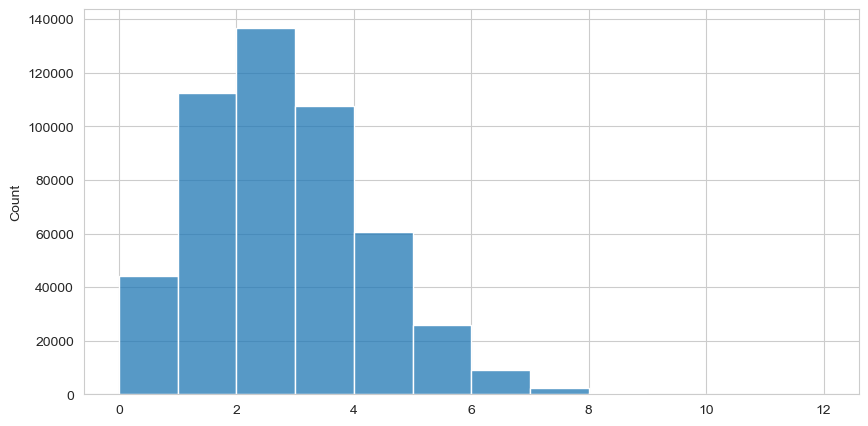

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns 
f,ax = plt.subplots(1,1, figsize=(10,5))
g =sns.histplot(x=n, binwidth=1, figure=f, axes=ax)
f.suptitle = 'N. of common participants between pairs of groups'
plt.savefig('./results/figures/supp-fig_data-leakage.png')

#### Supplementary Table : out of distribution

In [42]:
sample_dir = './results/samples/stargan-rh--rf'
model = 'stargan'
n = ''
w=''
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20, add_title='_outsample')

Model: stargan, n=, w=


/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [45]:
sample_dir = './results/samples/stargan-rf--rf'
model = 'stargan'
n = ''
w=''
sampling = ''

compute_metrics(sample_dir, p_source_list, p_target_list, model, n, w, sampling, nimg=20, add_title='_rf')

Model: stargan, n=, w=


/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [46]:
config = {
    'model':['stargan'], 
    'n' : [''],
    'sampling' : ['']
}

transfer = [
    (1,2),
    (2,1),
    (1,3),
    (1,0),
]

for i in range(len(config['model'])):
    printer_init = 'Source & '
    printer_rh = 'Trained RH & '
    printer_rf = 'Trained RF & '
    for t_idx, t in enumerate(transfer):
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]

        corr_df = f'./results/metrics/metrics-{model}-{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}_outsample.csv'
        df = pd.read_csv(corr_df)
        corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()
        corr_init = df['Correlation'].loc[df['Type']=='Source-Target'].tolist()
        printer_init += str(round(np.mean(corr_init)*100,1)) + ' & '
        printer_rh += str(round(np.mean(corr)*100,1)) + ' & '

        corr_df = f'./results/metrics/metrics-{model}-{pipelines[transfer[t_idx][0]]}_{pipelines[transfer[t_idx][1]]}_rf.csv'
        df = pd.read_csv(corr_df)
        corr = df['Correlation'].loc[df['Type']=='Target-Generated'].tolist()
        printer_rf += str(round(np.mean(corr)*100,1)) + ' & '

    print(printer_init)
    print(printer_rf)
    print(printer_rh)

Source & 86.2 & 86.3 & 85.8 & 95.9 & 
Trained RF & 90.5 & 88.8 & 88.9 & 93.1 & 
Trained RH & 71.2 & 71.0 & 63.0 & 82.2 & 


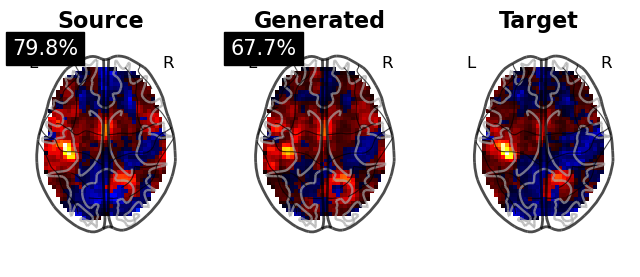

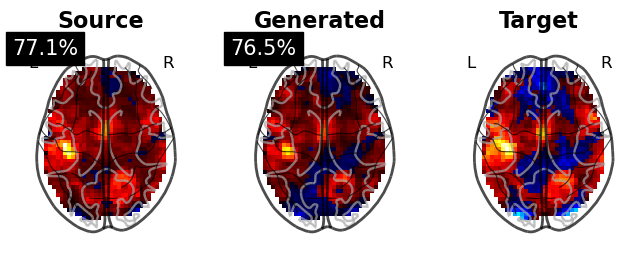

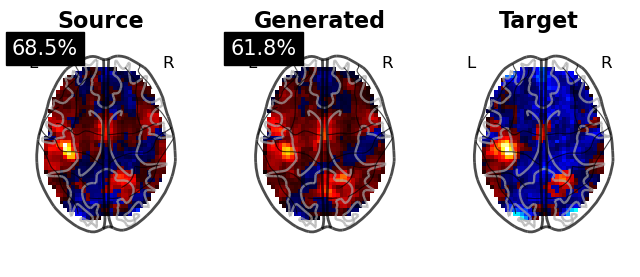

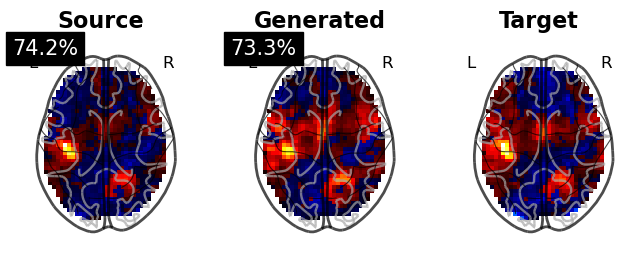

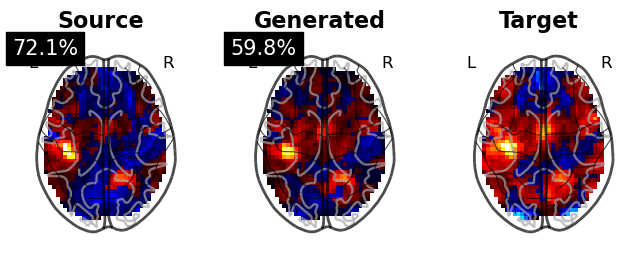

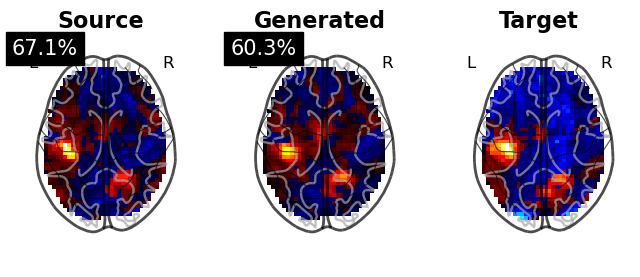

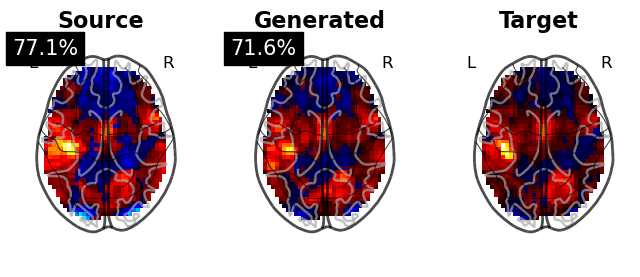

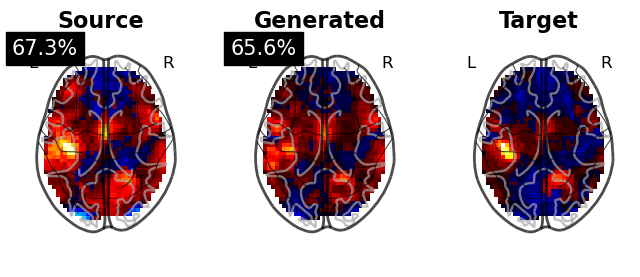

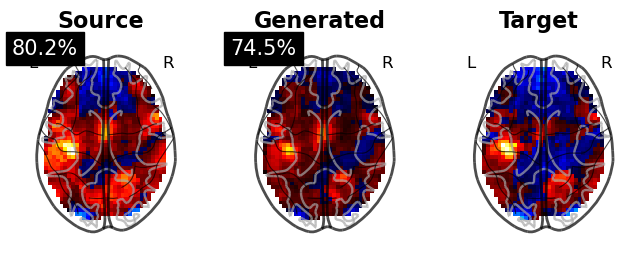

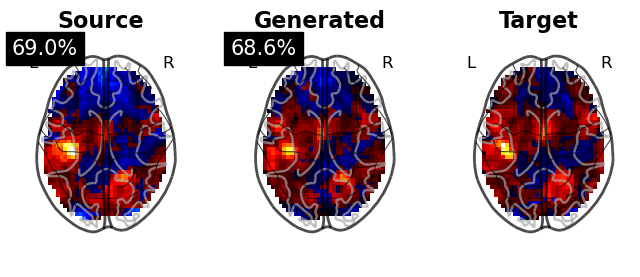

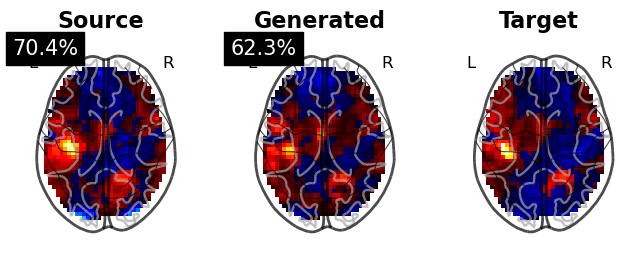

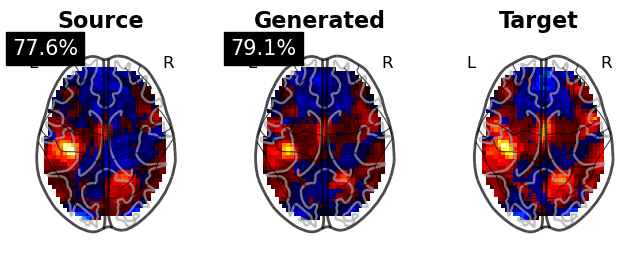

In [11]:
transfer = [(i,j) for i in range(4) for j in range(4) if i!=j]

for t_idx, t in enumerate(transfer):
    f,ax = plt.subplots(1,3, figsize=(8, 3))
    for i in range(len(config['model'])):
        printer = ''
        printer_orig = ''
            
        n = config['n'][i]
        sampling = config['sampling'][i]
        model = config['model'][i]
    
        sample_dir = f'./results/samples/{model}-rh--rf'
        #sample_dir = './stargan/samples-4classes-rf'

    
        gen_img_list = glob(
                    f'{sample_dir}/gen_img-*_orig-{p_source_list[t[0]]}_target-{p_target_list[t[1]]}.nii.gz')
        src_img_list = glob(
                    f'{sample_dir}/src_img-*_orig-{p_source_list[t[0]]}_target-{p_target_list[t[1]]}.nii.gz')
        trg_img_list = glob(
                    f'{sample_dir}/trg_img-*_orig-{p_source_list[t[0]]}_target-{p_target_list[t[1]]}.nii.gz')    
         # Initial 
        display = plotting.plot_glass_brain(
            src_img_list[0],
            colorbar=False,
            cmap=nilearn_cmaps['cold_hot'],
            title = str(round(metrics.get_correlation(nib.load(src_img_list[0]), nib.load(trg_img_list[0]))*100,1)) + '%',
            plot_abs=False, vmin=-1, 
            vmax=1,
            threshold=0,
            display_mode='z',
            figure=f, axes=ax[0], 
        )
        
        # Ground truth
        display = plotting.plot_glass_brain(
            trg_img_list[0],
            colorbar=False,
            cmap=nilearn_cmaps['cold_hot'],
            plot_abs=False,
            display_mode='z', vmin=-1, 
            vmax=1,
            threshold=0,
            figure=f, axes=ax[2],
        )
        # QC
        display = plotting.plot_glass_brain(
            metrics.mask(trg_img_list[0], gen_img_list[0]),
            colorbar=False,
            title =str(round(metrics.get_correlation(nib.load(gen_img_list[0]), nib.load(trg_img_list[0]))*100,1)) + '%', 
            cmap=nilearn_cmaps['cold_hot'],
            plot_abs=False, vmin=-1, 
            vmax=1,
            threshold=0,
            display_mode='z',
            figure=f, axes=ax[1], 
        )
    ax[0].set_title('Source', fontsize=16, fontweight='bold')
    ax[1].set_title('Generated', fontsize=16, fontweight='bold')
    ax[2].set_title('Target', fontsize=16, fontweight='bold')
    #f.suptitle(f'Transfer {pipelines[t[0]]} to {pipelines[t[1]]}', fontsize=16,/ fontweight='bold')

    #plt.savefig(f'./results/supp-figure_transfer-{pipelines[t[0]]}_{pipelines[t[1]]}.png')